# 将空洞卷积模型的实验结果与卷积模型的结果进行分析比对，训练时间、预测精度、Loss变化等角度分析


Training standard ConvNet model...
Epoch 1/15, Loss: 0.5979, Accuracy: 73.18%, Time: 39.64s
Epoch 2/15, Loss: 0.3102, Accuracy: 87.74%, Time: 79.86s
Epoch 3/15, Loss: 0.2019, Accuracy: 92.35%, Time: 133.86s
Epoch 4/15, Loss: 0.1378, Accuracy: 94.93%, Time: 186.90s
Epoch 5/15, Loss: 0.1279, Accuracy: 95.58%, Time: 250.23s
Epoch 6/15, Loss: 0.1033, Accuracy: 96.04%, Time: 304.20s
Epoch 7/15, Loss: 0.0647, Accuracy: 97.33%, Time: 358.02s
Epoch 8/15, Loss: 0.0504, Accuracy: 98.06%, Time: 1256.49s
Epoch 9/15, Loss: 0.0359, Accuracy: 99.26%, Time: 1308.84s
Epoch 10/15, Loss: 0.0723, Accuracy: 97.79%, Time: 1362.08s
Epoch 11/15, Loss: 0.0287, Accuracy: 98.71%, Time: 1412.10s
Epoch 12/15, Loss: 0.0403, Accuracy: 99.08%, Time: 1462.80s
Epoch 13/15, Loss: 0.0236, Accuracy: 99.54%, Time: 1513.51s
Epoch 14/15, Loss: 0.0193, Accuracy: 99.54%, Time: 1568.28s
Epoch 15/15, Loss: 0.0137, Accuracy: 99.54%, Time: 1623.51s

Training DilatedConvNet model...
Epoch 1/15, Loss: 0.8148, Accuracy: 62.21%, Time

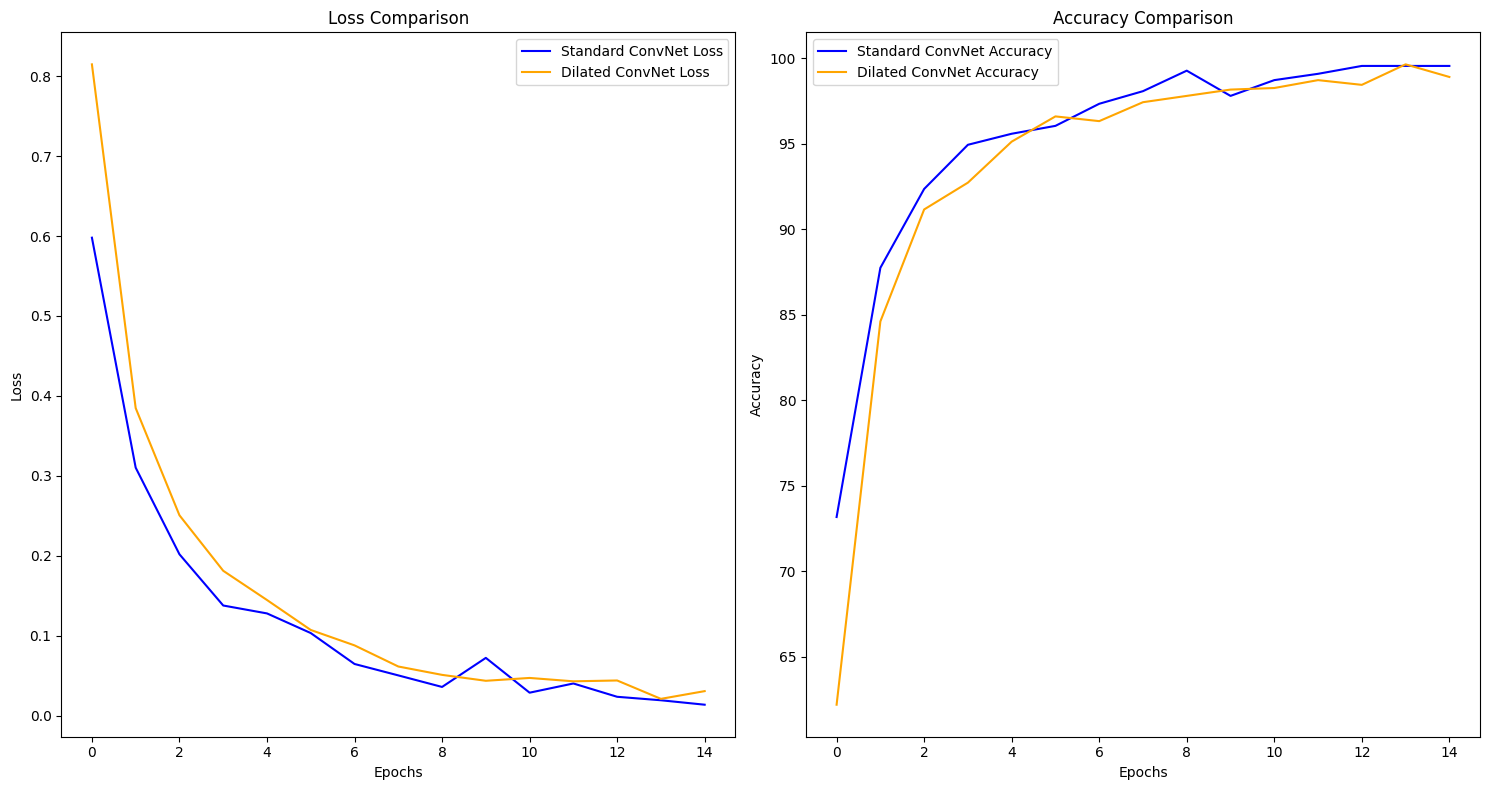

In [2]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

# 数据加载与预处理
class VehicleDataset(data.Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx])
        if self.transform:
            img = self.transform(img)
        
        label = self.labels[idx]
        return img, label

# 预处理步骤，包括调整图片大小和归一化
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 加载数据
def load_data(data_dir, test_size=0.2):  # 划分训练集和测试集
    labels = {'car': 0, 'bus': 1, 'truck': 2}
    img_paths = []
    img_labels = []

    # 遍历每个类别
    for label_name, label in labels.items():
        class_path = os.path.join(data_dir, label_name)
        for img_name in os.listdir(class_path):
            # 忽略隐藏文件和非图像文件
            if img_name.startswith('.') or not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
            img_path = os.path.join(class_path, img_name)
            img_paths.append(img_path)
            img_labels.append(label)

    # 划分训练集和测试集，随机抽取20-30%的数据作为测试集
    X_train, X_test, y_train, y_test = train_test_split(img_paths, img_labels, test_size=test_size, stratify=img_labels)
    
    train_dataset = VehicleDataset(X_train, y_train, transform)
    test_dataset = VehicleDataset(X_test, y_test, transform)
    
    return train_dataset, test_dataset

# 标准卷积网络（ConvNet）
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 3)  # 3个类别

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # 卷积层1 + ReLU + 池化
        x = self.pool(torch.relu(self.conv2(x)))  # 卷积层2 + ReLU + 池化
        x = x.view(x.size(0), -1)  # 展开为全连接层的输入
        x = torch.relu(self.fc1(x))  # 全连接层 + ReLU
        x = self.fc2(x)  # 输出层
        return x

# 空洞卷积网络（DilatedConvNet）
class DilatedConvNet(nn.Module):
    def __init__(self, dilation_rates=[1, 2, 5]):
        super(DilatedConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=dilation_rates[0], dilation=dilation_rates[0])
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=dilation_rates[1], dilation=dilation_rates[1])
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=dilation_rates[2], dilation=dilation_rates[2])
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 3)  # 3个类别

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # 空洞卷积1 + ReLU + 池化
        x = self.pool(torch.relu(self.conv2(x)))  # 空洞卷积2 + ReLU + 池化
        x = self.pool(torch.relu(self.conv3(x)))  # 空洞卷积3 + ReLU + 池化
        x = x.view(x.size(0), -1)  # 展开为全连接层的输入
        x = torch.relu(self.fc1(x))  # 全连接层 + ReLU
        x = self.fc2(x)  # 输出层
        return x

# 训练模型
def train_model(train_loader, test_loader, model, criterion, optimizer, epochs=5):
    loss_history = []
    accuracy_history = []
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            # 计算准确率
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        avg_loss = running_loss / len(train_loader)
        accuracy = 100 * correct_predictions / total_samples
        loss_history.append(avg_loss)
        accuracy_history.append(accuracy)

        epoch_time = time.time() - start_time
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%, Time: {epoch_time:.2f}s')

    return loss_history, accuracy_history, time.time() - start_time

# 可视化结果
def plot_comparison_results(standard_loss, dilated_loss, standard_accuracy, dilated_accuracy):
    plt.figure(figsize=(15, 8))

    # 绘制损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(standard_loss, label='Standard ConvNet Loss', color='blue')
    plt.plot(dilated_loss, label='Dilated ConvNet Loss', color='orange')
    plt.title('Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 绘制准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(standard_accuracy, label='Standard ConvNet Accuracy', color='blue')
    plt.plot(dilated_accuracy, label='Dilated ConvNet Accuracy', color='orange')
    plt.title('Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 设置数据集路径
data_dir = r"C:\Users\37623\jupyter_test\Lab4\datasets\Vehicle_classification_dataset"

# 加载数据
train_dataset, test_dataset = load_data(data_dir)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# 初始化模型、损失函数和优化器
standard_model = ConvNet()
dilated_model = DilatedConvNet(dilation_rates=[1, 2, 5])

# 选择优化器
standard_optimizer = optim.SGD(standard_model.parameters(), lr=0.01, momentum=0.9)
dilated_optimizer = optim.SGD(dilated_model.parameters(), lr=0.01, momentum=0.9)

# 训练标准卷积模型
print("\nTraining standard ConvNet model...")
standard_loss_history, standard_accuracy_history, standard_training_time = train_model(
    train_loader, test_loader, standard_model, nn.CrossEntropyLoss(), standard_optimizer, epochs=15
)

# 训练空洞卷积模型
print("\nTraining DilatedConvNet model...")
dilated_loss_history, dilated_accuracy_history, dilated_training_time = train_model(
    train_loader, test_loader, dilated_model, nn.CrossEntropyLoss(), dilated_optimizer, epochs=15
)

# 输出训练时间
print(f"Standard ConvNet Training Time: {standard_training_time:.2f} seconds")
print(f"Dilated ConvNet Training Time: {dilated_training_time:.2f} seconds")

# 绘制训练结果对比图
plot_comparison_results(standard_loss_history, dilated_loss_history, standard_accuracy_history, dilated_accuracy_history)
